# Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np

from scipy.stats import spearmanr
from scipy import stats as st

import math as mth

import matplotlib.pyplot as plt

from sklearn.model_selection import (train_test_split,
                                    cross_val_score,
                                    KFold,
                                    GridSearchCV)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (f1_score,
                             precision_score,
                             recall_score,
                             make_scorer)
from sklearn.pipeline import (Pipeline,
                              make_pipeline)
from sklearn.preprocessing import (OneHotEncoder,
                                   StandardScaler)
from sklearn.compose import ColumnTransformer

from catboost import CatBoostClassifier
from catboost import Pool
from catboost import cv

import warnings

# Глобальные переменные

In [2]:
RANDOM_STATE = 123

# bar colors
COLOR_CHURN = 'tomato'
COLOR_NOT_CHURN = 'darkgray'

In [3]:
warnings.filterwarnings('ignore')

# Описание проекта, цели и задачи

**Цель:**
- провести анализ и выделить сегменты клиентов, которые более склонны к уходу;
- сформулировать возможные причины ухода;
- сформулировать рекомендации по сокращению оттока
- разработать прототип ML модели для предсказания возможного ухода клиента.

# Загрузка данных

In [4]:
# загрузка из локального файла

data = pd.read_csv('bank_dataset.csv')

# Оценка качества данных, предобработка данных

In [5]:
data.head(1)

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1


## Название столбцов

In [6]:
# приведем названия столбцов к нижнему регистру
# разделим названия столбцов из нескольких слов '_'

data.columns = [col.lower() for col in data.columns]

data = data.rename(columns={
                            'userid':'user_id',
                            'creditcard':'credit_card'
                            })

## Пропущенные значения

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   city              10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   objects           10000 non-null  int64  
 6   balance           6383 non-null   float64
 7   products          10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


___
Пропуски в одном столбце - 'balance'. Пропущенных значений порядка 36%. Можно отметить, что минимальное значение более 0, можно сделать предположение, что нулевой боланас записывается как пустое значение. Заполним пропуски на 0. Опять же при необходимости сможем легко отфильтровать.
___

In [8]:
data['balance'] = data['balance'].fillna(0)

## Тип данных

Тип данных оставляем без изменений

## Дубли

In [9]:
data.nunique()

user_id             10000
score                 460
city                    3
gender                  2
age                    70
objects                11
balance              6382
products                4
credit_card             2
loyalty                 2
estimated_salary     9999
churn                   2
dtype: int64

___
- отсутсвуют дубли user_id;
- два уникальных обозначения признаков: пол, наличие кредитной карты, лояльность, отток;
- три уникальных обозначения городов.
___

## Аномальные значения

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,10000.0,1.573368e+07,71936.186123,15608437.00,15671264.25,1.573347e+07,1.579597e+07,15858426.00
score,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
objects,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
products,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
credit_card,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
loyalty,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
estimated_salary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48
churn,10000.0,2.037000e-01,0.402769,0.00,0.00,0.000000e+00,0.000000e+00,1.00


---
можно отметить аномально низкое значение заработной платы.

---

### оценочный уровень дохода

In [11]:
def outliers_box_hist(df_col,
                     box_title='',
                     hist_title=''):
    plt.figure(figsize=(12, 4))

    # настройка шкалы OX    
    x_ticks = np.arange(0, df_col.max()+25_000, 25_000)

    # boxplot
    plt.subplot(1, 2, 1)
    df_col.plot(kind='box', vert=False)

    plt.title(box_title)
    plt.xlabel('тыс. руб.')
    plt.xticks(x_ticks, [int(i) for i in x_ticks/1000])

    # гистограмма
    plt.subplot(1, 2, 2)

    plt.hist(df_col,
             weights=np.ones(len(df_col))/len(df_col), bins=50
            )

    plt.title(hist_title)
    plt.xlabel('тыс. руб.')
    plt.ylabel('доля клиентов')
    plt.xticks(x_ticks, [int(i) for i in x_ticks/1000])
    plt.subplots_adjust(wspace=0.4);

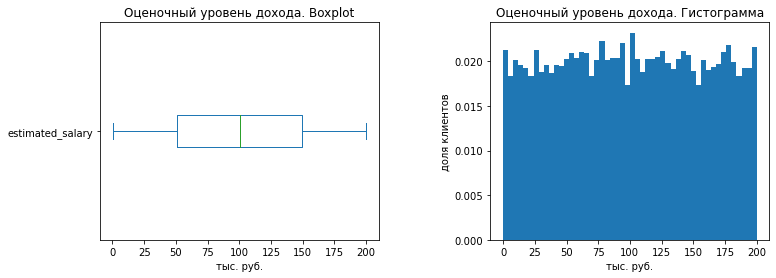

In [12]:
outliers_box_hist(data['estimated_salary'],
                    box_title='Оценочный уровень дохода. Boxplot',
                    hist_title='Оценочный уровень дохода. Гистограмма' )

___
**Можем отметить:**
- равномерное распределение оценочночного дохода среди клиентов;
- отсутсвие аномальных значений;
- т.к. у нас нет информации о методике оценки уровня дохода и точности оценки, сделаем предположение, крайне малые значения могут быть результатом выплаты процентов по депозиту, начисления процентов на остаток по карте, кешбэк и т.д.. Поэтому оставим значения без изменений.
___

### баланс

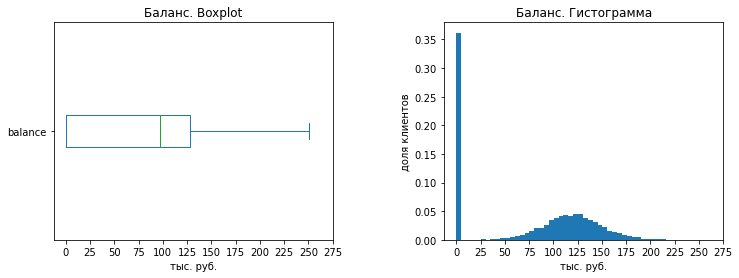

In [13]:
outliers_box_hist(data['balance'],
                    box_title='Баланс. Boxplot',
                    hist_title='Баланс. Гистограмма' )

___
**Можем отметить:**
- если не рассматривать заполненные "0" пропущенные значение, распределение близкое к нормальному;
- отсутсвие аномальных значений.
___


# EDA

## Общее количество ушедших клиентов

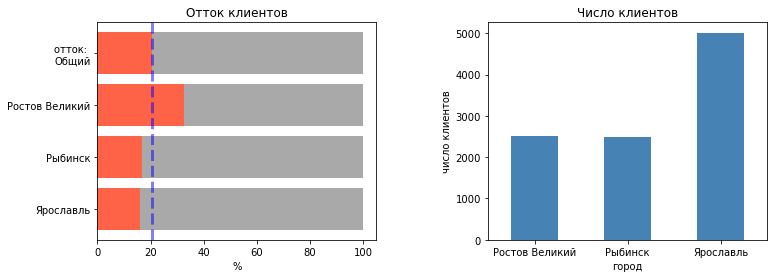

In [14]:
# создадим пустой df
churn_df = pd.DataFrame({'churn'})

# значение оттока
churn_mean = round(data['churn'].mean()*100, 2)
churn_df.loc['total'] = churn_mean

plt.figure(figsize=(12, 4))

# график оттока
plt.subplot(1, 2, 1)

for city in data['city'].unique():
    churn_city = round(data.query('city == @city')['churn'].mean()*100, 2)
    plt.barh(city,churn_city, color=COLOR_CHURN)
    plt.barh(city, 100-churn_city, left=churn_city, color=COLOR_NOT_CHURN)
    
    churn_df.loc[city] = churn_city
    
plt.barh('отток: \nОбщий',churn_mean, color=COLOR_CHURN)
plt.barh('отток: \nОбщий', 100-churn_mean, left=churn_mean, color=COLOR_NOT_CHURN)

plt.title('Отток клиентов')
plt.xlabel('%')

plt.axvline(churn_mean, color='blue', linestyle='--', linewidth=3, alpha=0.5)

# график общее число клиентов
plt.subplot(1, 2, 2)
data['city'].value_counts().sort_index().plot(kind='bar', color='steelblue')
plt.title('Число клиентов')
plt.ylabel('число клиентов')
plt.xticks(rotation = 0)
plt.xlabel('город');

plt.subplots_adjust(wspace=0.4);

In [15]:
# df общее число клиентов по городам

clients_count = pd.DataFrame(data['city'].value_counts())\
            .rename(columns={'city':'clients'})\
            .sort_index(ascending=False)

clients_count = pd.concat([pd.DataFrame({'clients': [data['user_id'].count()]}, index=['total']),
         clients_count])

In [16]:
display(churn_df.T,
        clients_count.T)

,0,total,Ярославль,Рыбинск,Ростов Великий
0,churn,20.37,16.15,16.67,32.44


,total,Ярославль,Рыбинск,Ростов Великий
clients,10000,5014,2477,2509


___
**Можем отметить:**
- наибольшее число клиентов в Ярославле;
- наименьшее число клиентов в Рыбинске;
- наибольшее число ушедших клиентов в Ростове Великом;
- процент оттка в Ростове Великом в два раза больше чем в Рыбинске или Ярославле;
___

## Баллы кредитного скоринга

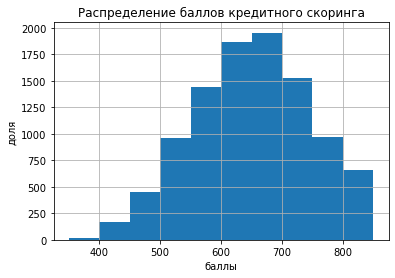

In [17]:
# распределение баллов кредитного скоринга

data['score'].hist()
plt.title('Распределение баллов кредитного скоринга')
plt.xlabel('баллы')
plt.ylabel('доля');

In [18]:
# сгруппируем значения кредитного скоринга

score_group = [data['score'].min()-1, 500, 600, 700, 800, data['score'].max()]

data['score_group'] = pd.cut(data['score'], score_group)

In [19]:
# расчет оттока клиентов

class churn_class:
    def __init__(self, df_):
        self.df_ = df_
    
    # общий отток
    def churn_total(self, col):
        group_churn = self.df_.groupby(col).agg({'churn':'mean'}).round(2).sort_index()
        
        return group_churn
    
    # в разрезе городов
    def churn_city(self, city, col):
        city_churn = self.df_.query('city == @city').groupby(col).agg({'churn':'mean'}).round(2).sort_index()
        
        return city_churn

In [20]:
def churn_bar_plot(churn_data,
                  title=''
                  ):
    '''
    bar_plot отток клиентов
    '''
    # график
    plt.bar(range(len(churn_data)), churn_data['churn']*100,
        tick_label=churn_data.index.values,
        color=COLOR_CHURN)

    plt.title(title)
    plt.ylabel('%')
    plt.xticks(rotation = 0)
    
    # mean churn
    plt.axhline(churn_mean, color='blue', linestyle='--', linewidth=3, alpha=0.5);

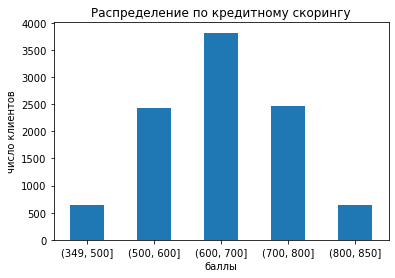

In [21]:
data['score_group'].value_counts().sort_index().plot(kind='bar')
plt.title('Распределение по кредитному скорингу')
plt.ylabel('число клиентов')
plt.xlabel('баллы')
plt.xticks(rotation=0);

In [22]:
# создадим экземпляр класса для расчета оттока

churn = churn_class(data)

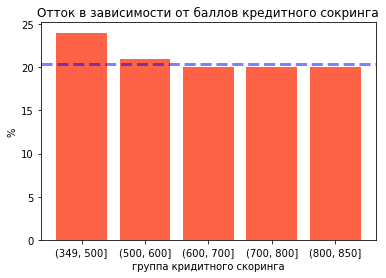

In [23]:
# отток в зависимости от баллов кредитного скоринга
score_group_churn = churn.churn_total('score_group')

# график
churn_bar_plot(score_group_churn, 
              title='Отток в зависимости от баллов кредитного сокринга'
              )
plt.xlabel('группа кридитного скоринга');

In [24]:
def churn_city_bar_plot(churn_data,
                        col,
                        figsize=(18, 4),
                        ylim='',
                        xticks=''):
    '''
    bar plot отток клиентов по городам
    '''
    # счетчик графиков
    plot_num = 1

    plt.figure(figsize=figsize)
    for city in data['city'].unique():
        plt.subplot(1, 3, plot_num)
        
        # df оттока в разрезе города
        score_group_churn_city = churn.churn_city(city, col)
        
        # график
        churn_bar_plot(score_group_churn_city, 
                  title=city
                  )
        plt.xlabel(col)
        
        # опционально единая шкала
        if ylim:
            plt.ylim(ylim)
            
        if xticks:
            plt.xticks(*xticks)
            
        plot_num +=1

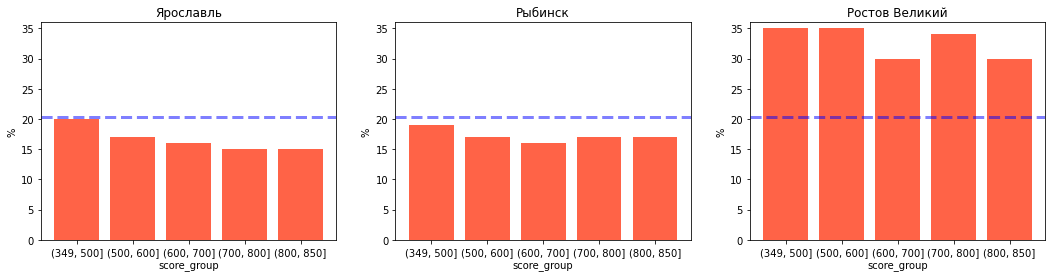

In [25]:
# отток в зависимости от балловк кредитного скоринга по городам

churn_city_bar_plot(churn, 'score_group',
                        figsize=(18, 4),
                        ylim=(0, 36))

___
**Можно отметить:**
- уровень оттока находится в диапазоне 19-32%;
- 32% оттока имеют клиенты с рейтингом от 350 до 450. За исключением данной категории % оттока от 19 до 22%.
- в Ростове Великом превышение показателя оттока клиентов по всем группам кредитного рейтинга.
___

## Пол

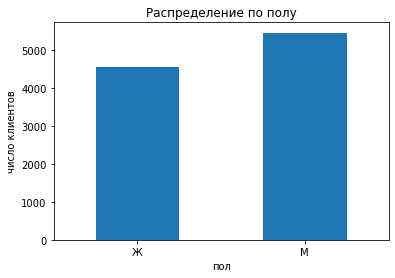

In [26]:
# количество клиентов в зависимости от пола

data['gender'].value_counts()[::-1].plot(kind='bar')
plt.title('Распределение по полу')
plt.ylabel('число клиентов')
plt.xlabel('пол')
plt.xticks(rotation=0);

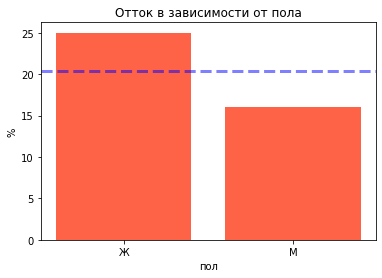

In [27]:
# отток клиентов в зависимости от пола

score_group_churn = churn.churn_total('gender')

churn_bar_plot(score_group_churn, 
              title='Отток в зависимости от пола'
              )
plt.xlabel('пол');

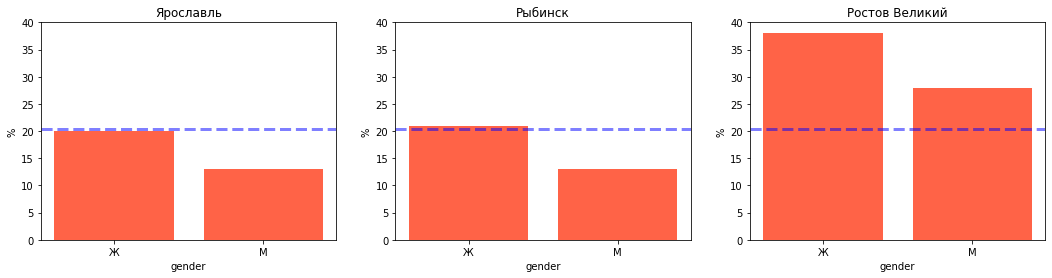

In [28]:
# отток клиентов в зависимости от пола по городам

churn_city_bar_plot(churn, 'gender',
                        figsize=(18, 4),
                        ylim=(0, 40))

**Можно отметить** в Ростове Великом превышение показателя оттока клиентов как среди мужчин, так и женщин.

## Возраст

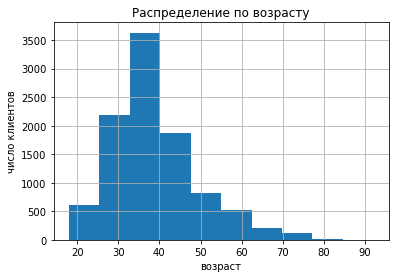

In [29]:
data['age'].hist()
plt.title('Распределение по возрасту')
plt.ylabel('число клиентов')
plt.xlabel('возраст');

In [30]:
print(f"минимальны возраст - {data['age'].min()}")
print(f"максимальный возраст - {data['age'].max()}")

минимальны возраст - 18
максимальный возраст - 92


In [31]:
# сгруппируем клиентов по возрасту

age_group = [data['age'].min()-1, 25, 35, 45, 55, 65, data['age'].max()]

data['age_group'] = pd.cut(data['age'], age_group)

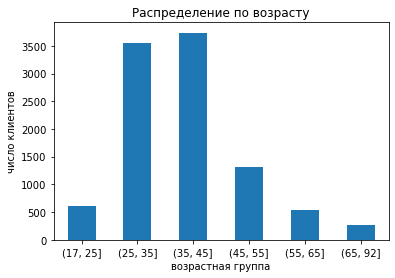

In [32]:
# количество клиентов по возрастным группам

data['age_group'].value_counts().sort_index().plot(kind='bar')
plt.title('Распределение по возрасту')
plt.ylabel('число клиентов')
plt.xlabel('возрастная группа')
plt.xticks(rotation=0);

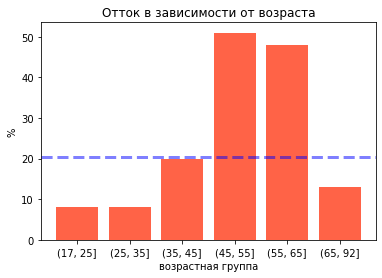

In [33]:
# отток клиентов по возрастным группам

score_group_churn = churn.churn_total('age_group')

churn_bar_plot(score_group_churn, 
              title='Отток в зависимости от возраста'
              )
plt.xlabel('возрастная группа');

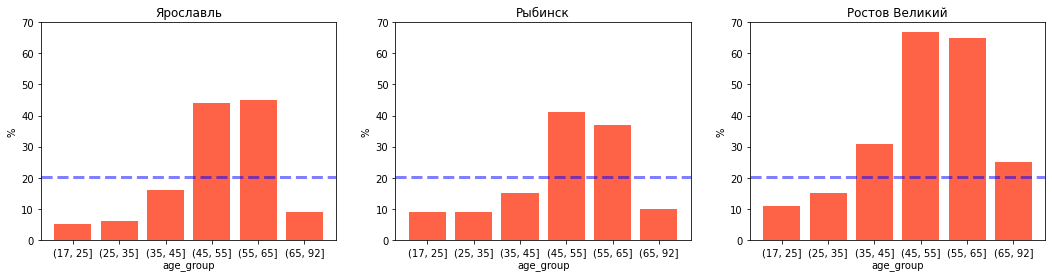

In [34]:
# отток клиентов по возрастным группам в городах

churn_city_bar_plot(churn, 'age_group',
                        figsize=(18, 4),
                        ylim=(0, 70))

___
**Можно отметить:**
- диапазон значений оттока от 8 до 51 %
- отток ниже среднего - 8% для возрастных групп от 17 до 25 и от 25 до 35 лет, 13 для возрастной группы от 65 лет
- отток выше среднего 51 и 48 для возрастных групп от 45 до 55 и от 55 до 65 лет.
- можно сделать предположения, подобные значения оттока связаны с параметрами(условиями) продуктов;
- для формирования рекомендаций необходимо более обоснованное предположение о причинах оттока, в частности данные по параметрам продуктов, стратегия банка, конкурентный анализ.
- в Ростове Великом превышение показателя оттока клиентов по всем возрастным группам.
___

## Количество объектов

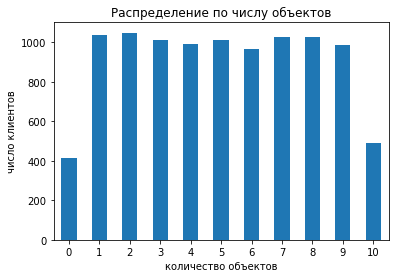

In [35]:
# число клиентов обладающих количеством объктов

data['objects'].value_counts().sort_index().plot(kind='bar')
plt.title('Распределение по числу объектов')
plt.ylabel('число клиентов')
plt.xlabel('количество объектов')
plt.xticks(rotation=0);

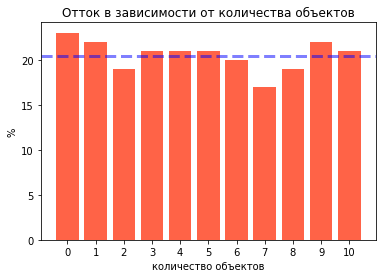

In [36]:
# отток клиентов обладающих количеством объктов

score_group_churn = churn.churn_total('objects')

churn_bar_plot(score_group_churn, 
              title='Отток в зависимости от количества объектов'
              )
plt.xlabel('количество объектов');

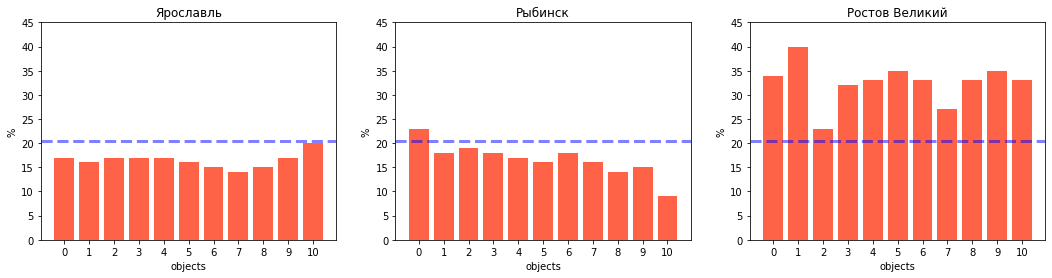

In [37]:
# отток клиентов обладающих количеством объктов в городах

churn_city_bar_plot(churn, 'objects',
                        figsize=(18, 4),
                        ylim=(0, 45))

**Можно отметить:**
- диапазон значений оттока от 17 до 23 %;
- отсутсвие ярко выраженной корреляции;
- можно сделать вывод об отсутсвии связи между количеством объектов и уровнем оттока клиентов.
- Превышение оттока в Ростове Великом по всем категориям;

## Баланс

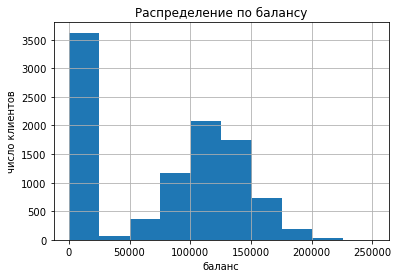

In [38]:
# количество клиентов с уровнем баланса

data['balance'].hist()
plt.title('Распределение по балансу')
plt.ylabel('число клиентов')
plt.xlabel('баланс');

In [39]:
# сгруппируем значения баланса

balance_group = [-1, 0, 50_000, 100_000, 150_000, 200_000, data['balance'].max()]

data['balance_group'] = pd.cut(data['balance'], balance_group)

In [40]:
# настройки оси X
def set_xlabel(group_, multiplier=1000):
    x_label_list = []

    for i, ii in enumerate(group_):
        if ii == group_[-1]:
            break
        elif ii == group_[0]:
            x_label_list.append(f'0')
        else:
            x_label_list.append(f'от {int(group_[i]/multiplier)}\n до {int(group_[i+1]/multiplier)}')
            
    return x_label_list

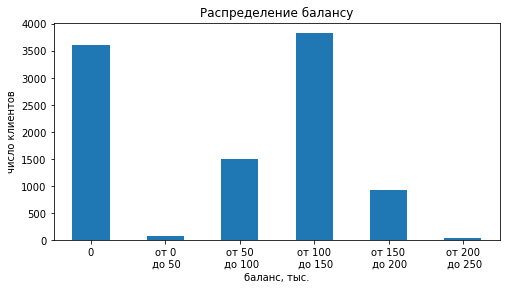

In [41]:
# количество клиентов в группе с уровнем баланса

x_label = set_xlabel(balance_group)

plt.figure(figsize=(8, 4))

data['balance_group'].value_counts().sort_index().plot(kind='bar')
plt.title('Распределение балансу')
plt.ylabel('число клиентов')
plt.xlabel('баланс, тыс.')
plt.xticks(np.arange(len(balance_group)-1), x_label, rotation=0);

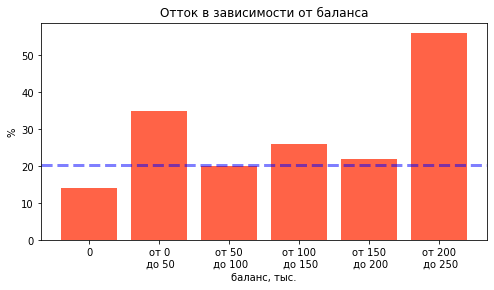

In [42]:
# замена шкалы Х
xticks=[np.arange(len(balance_group)-1), x_label]


# отток клиентов в группе с уровнем баланса
plt.figure(figsize=(8, 4))

score_group_churn = churn.churn_total('balance_group')

churn_bar_plot(score_group_churn, 
              title='Отток в зависимости от баланса'
              )
plt.xticks(*xticks)
plt.xlabel('баланс, тыс.');

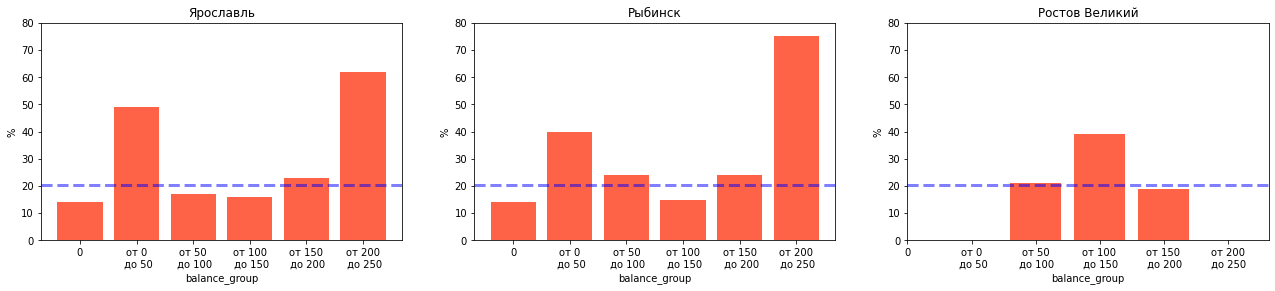

In [43]:
# отток клиентов в группе с уровнем баланса в городах

churn_city_bar_plot(churn, 'balance_group',
                        figsize=(22, 4),
                        ylim=(0, 80),
                        xticks=xticks)

**Можно отметить:**
- Отсутсвие ярко выраженной корреляции между балансом и % оттока клиентов;
- Следует обратить внимание, что клиенты с 0-м балансом имеют ниже показатель оттока (14%). Следует помнить, что баланс - 0, результат восстановаления пропущенных значений. Следует выяснить причины пропусков.
- Отток клиентов с крайними значениями баланса имеет повышенные значения оттока, 35 и 29. Следует ометить небольшое количество клиентов в данных группах: 0.75% и 2.3%. Можно выдвинуть гипотезу, что продукты банка и стандарты работы с клиентами не подходят для работы с клиентами как с небольшим так большим балансом.
- Следует отметить для самой многочисленной группы 100 000 - 125 000 % оттока составляет 27%.
- Следует выяснить методологию определения баланса, в частности по ушедшим клиентам определяется на момент ухода или иным способом;
- Характер распределения в Ростове Великом (минимальный отток на крайних значениях баланса, увеличивается к среднему значению) прямо противоположен характеру распределения в Ярославле и Рыбинске (показатели оттока выше на краях значений баланса, уменьшаются к центральному значению)
- Можно выдвинуть гипотезу: в Ростове Великом попытались сократить показатели оттка для клиентов с крайними значениями баланса, добились в этом успеха, но при этом ухудшили показатель оттока для осталных клиентов.
- Пиковое значение оттока в Ростове Великом - 42% приходится на самую многочисленную группу 100 000 - 125 000р., этим и обясняется повышенные значения оттока на общем графике.
- Следует обратить внимание в Ростове Великом отсутсвуют клиенты с отсутсвующими значениями баланса.

## Количество продуктов

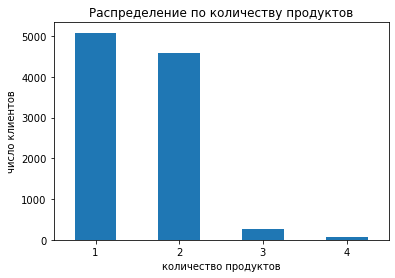

In [44]:
# число клиентов в зависимости о количества продуктов

data['products'].value_counts().sort_index().plot(kind='bar')
plt.title('Распределение по количеству продуктов')
plt.ylabel('число клиентов')
plt.xlabel('количество продуктов')
plt.xticks(rotation=0);

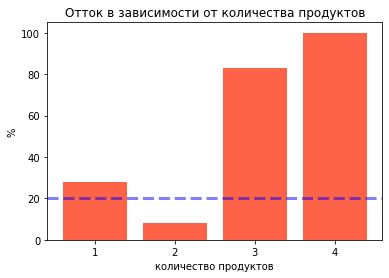

In [45]:
# отток клиентов в зависимости о количества продуктов

score_group_churn = churn.churn_total('products')

churn_bar_plot(score_group_churn, 
              title='Отток в зависимости от количества продуктов'
              )
plt.xlabel('количество продуктов');

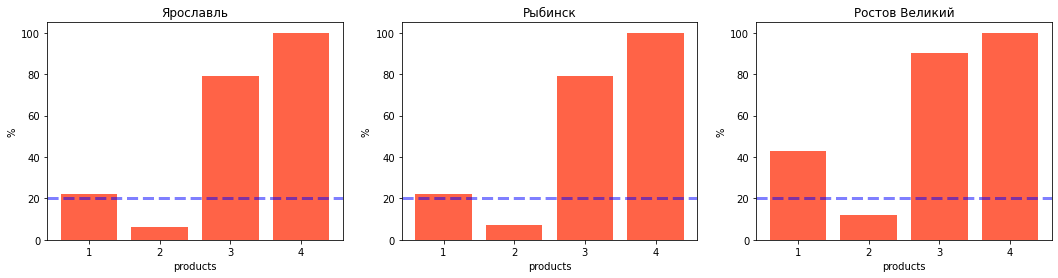

In [46]:
# отток клиентов в зависимости о количества продуктов в городах

churn_city_bar_plot(churn, 'products',
                        figsize=(18, 4),
                        ylim=(0, 105))

**Можно отметить:**
- отток клиентов имеющих два продукта ниже чем имеющих один, но отток клиентов имеющих три и четыре продука выше чем имеющих один и два;
- разброс значений относительно среднего % оттока от -12.4% до 79.6%(объединили 3 и 4 продукт)
- количество клиентов имеющих три и четыре продукта составляет 3% от общего числа клиентов;
- различия оттока клиентов имеющих 3 и 4 продукта менее выражены мужду Ростовом Великим и Ярославлем, Рыбинском.

**Можно предположить:**
- один - минимальное количество продуктов, клиенты еще могли не получить положительный или отрицательный опыт использования продуктов банка;
- второй продукт оформляют клиенты получившие положительный опыт использования первого продукта и более лояльные к банку;
- третий и четвертый - рузультат "успешной" продажи. 

Для более обоснованных предположений следует уточнить сценарии получения 2, 3 и 4 продуктов.

## Наличие кредитной карты

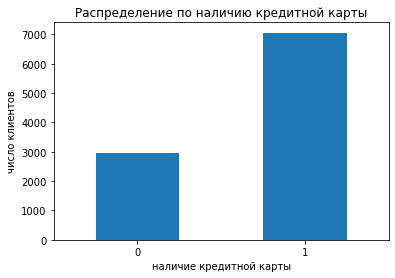

In [47]:
# количество клиентов с кредитной картой и без

data['credit_card'].value_counts()[::-1].plot(kind='bar')
plt.title('Распределение по наличию кредитной карты')
plt.ylabel('число клиентов')
plt.xlabel('наличие кредитной карты')
plt.xticks(rotation=0);

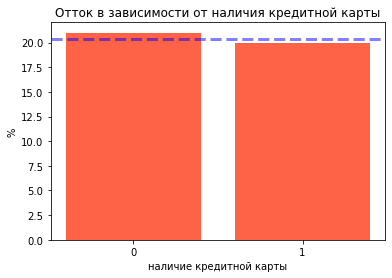

In [48]:
# отток клиентов с кредитной картой и без

score_group_churn = churn.churn_total('credit_card')

churn_bar_plot(score_group_churn, 
              title='Отток в зависимости от наличия кредитной карты'
              )
plt.xlabel('наличие кредитной карты');

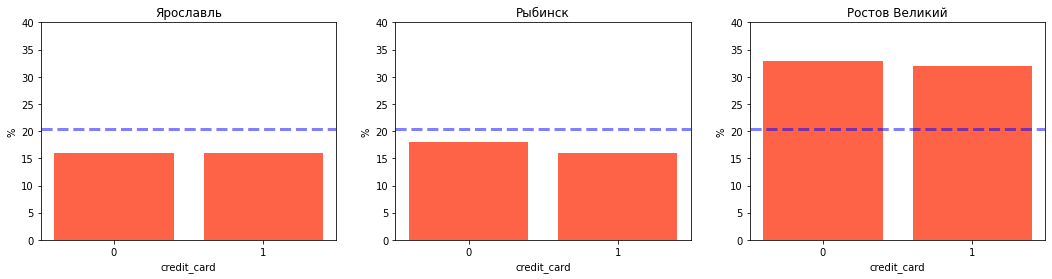

In [49]:
# отток клиентов с кредитной картой и без в городах

churn_city_bar_plot(churn, 'credit_card',
                        figsize=(18, 4),
                        ylim=(0, 40))

## Активность клиентов

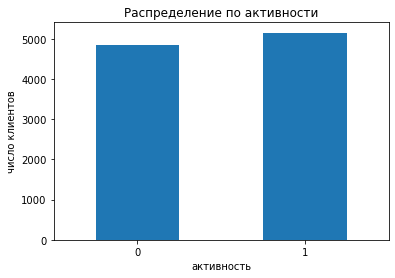

In [50]:
# количество клиентов в зависимости от активности

data['loyalty'].value_counts()[::-1].plot(kind='bar')
plt.title('Распределение по активности')
plt.ylabel('число клиентов')
plt.xlabel('активность')
plt.xticks(rotation=0);

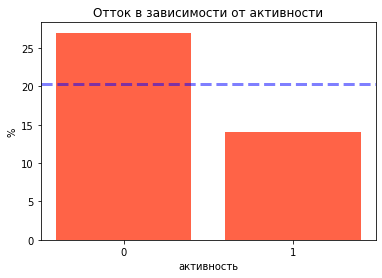

In [51]:
# отток клиентов в зависимости от активности

score_group_churn = churn.churn_total('loyalty')

churn_bar_plot(score_group_churn, 
              title='Отток в зависимости от активности'
              )
plt.xlabel('активность');

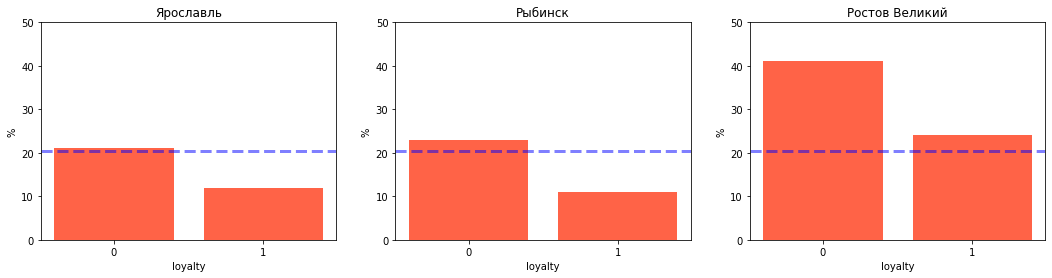

In [52]:
# отток клиентов в зависимости от активности в городах

churn_city_bar_plot(churn, 'loyalty',
                        figsize=(18, 4),
                        ylim=(0, 50))

___
**Можем отметить:** 
- Процент ушедших клиентов среди неактивных почти в два раза выше;
- Количество ушедших клиентов в Ростове Великом выше по обеим категориям.
___

## Оценка дохода

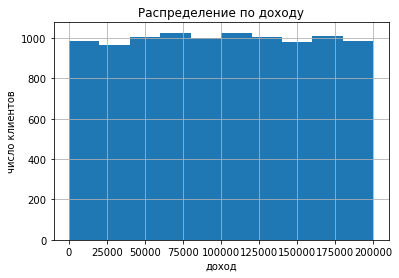

In [53]:
data['estimated_salary'].hist()
plt.title('Распределение по доходу')
plt.ylabel('число клиентов')
plt.xlabel('доход');

In [54]:
# сгруппируем значения дохода

estimated_salary_group = np.arange(0, data['estimated_salary'].max() + 25000, 25000)

data['estimated_salary_group'] = pd.cut(data['estimated_salary'], estimated_salary_group)

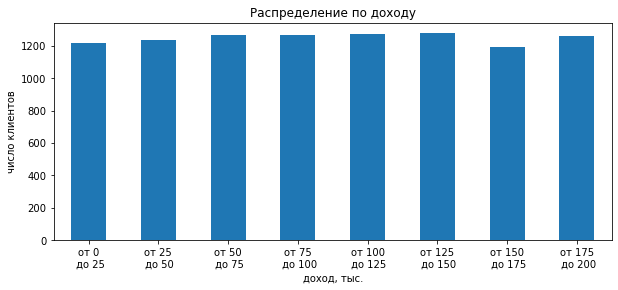

In [55]:
# настройки оси OX
x_label = []

for i, ii in enumerate(estimated_salary_group):
    if ii == estimated_salary_group[-1]:
        break
    else:
        x_label.append(f'от {int(estimated_salary_group[i]/1000)}\n до {int(estimated_salary_group[i+1]/1000)}')

plt.figure(figsize=(10, 4))

# число клиентов в зависмости от группы дохода
data['estimated_salary_group'].value_counts().sort_index().plot(kind='bar')
plt.title('Распределение по доходу')
plt.ylabel('число клиентов')
plt.xlabel('доход, тыс.')
plt.xticks(np.arange(len(estimated_salary_group)-1), x_label, rotation=0);

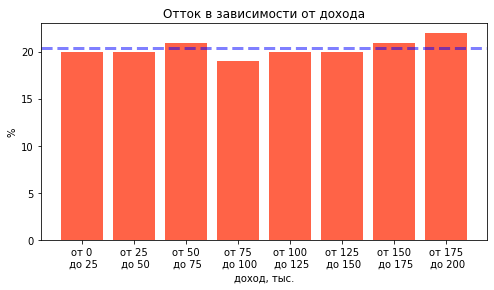

In [56]:
# замена шкалы Х
xticks=[np.arange(len(estimated_salary_group)-1), x_label]

plt.figure(figsize=(8, 4))

# отток клиентов в зависмости от группы дохода
score_group_churn = churn.churn_total('estimated_salary_group')

churn_bar_plot(score_group_churn, 
              title='Отток в зависимости от дохода'
              )
plt.xticks(*xticks)
plt.xlabel('доход, тыс.');

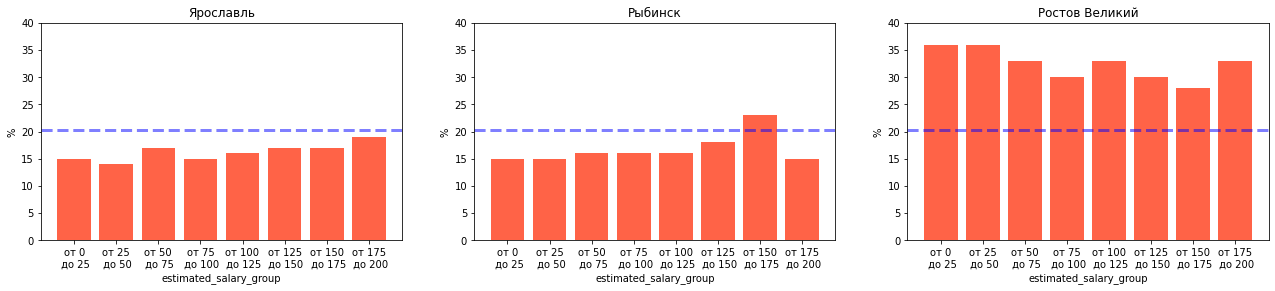

In [57]:
# отток клиентов в зависмости от группы дохода в городах

churn_city_bar_plot(churn, 'estimated_salary_group',
                        figsize=(22, 4),
                        ylim=(0, 40),
                        xticks=xticks);

**Можно отметить:**
- Диапазон значений оттока от 19 до 22 % без какой-либо ярко выраженной динамики. Что говорит об отсутсвия связи между оценочным уровнем з/п и оттокам клиентов;
- в Ростове Великом превышение показателя оттока клиентов по всем группам з/п.

# Разработка прототипа модели

## Feature engineering

### age__estimated_salary

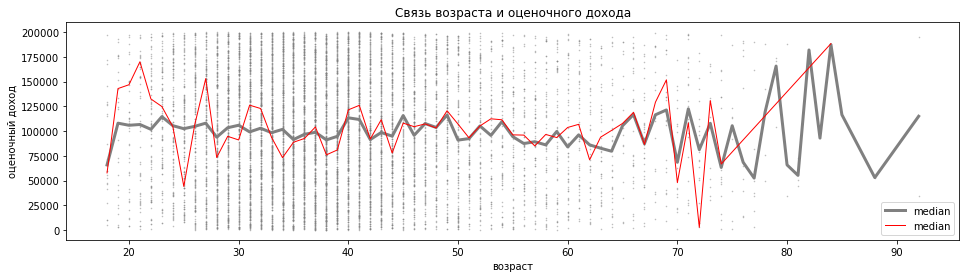

In [58]:
# график scatterplot: estimated_salary - age
# график lineplot: медиана estimated_salary

plt.figure(figsize=(16, 4))

# точечный график
plt.scatter(data['age'], data['estimated_salary'],
           s=.3, c='grey', alpha=0.5)

# линейный график
plt.plot(data.groupby('age').agg({'estimated_salary':'median'}),
        c='grey', label='median', linewidth=3)

# линейный график ушедшие клиенты
plt.plot(data.query('churn == 1').groupby('age').agg({'estimated_salary':'median'}),
        c='red', label='median', linewidth=1)

plt.legend()
plt.title('Связь возраста и оценочного дохода')
plt.xlabel('возраст')
plt.ylabel('оценочный доход');

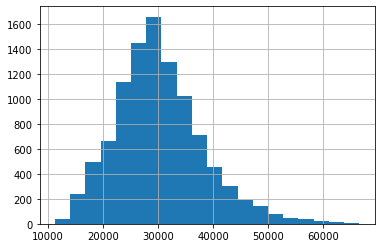

In [59]:
# построим признак: estimated_salary/age
# для распределения близкого к нормальному прибавим к estimated_salary 1_000_000

data['estimated_salary_age'] = (data['estimated_salary']+1_000_000)/data['age']

data['estimated_salary_age'].hist(bins=20);

In [60]:
# сгруппируем значения дохода

estimated_salary_age_group = np.arange(0, data['estimated_salary_age'].max() + 5_000, 5_000)

data['estimated_salary_age_group'] = pd.cut(data['estimated_salary_age'], estimated_salary_age_group)

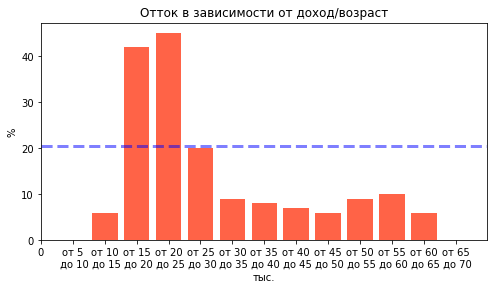

In [61]:
# настройка шкалы Х
x_label = set_xlabel(estimated_salary_age_group, multiplier=1000)

# замена шкалы Х
xticks=[np.arange(len(estimated_salary_age_group)-1), x_label]

plt.figure(figsize=(8, 4))

estimated_salary_age_group_churn = churn.churn_total('estimated_salary_age_group')

churn_bar_plot(estimated_salary_age_group_churn, 
              title='Отток в зависимости от доход/возраст'
              )
plt.xticks(*xticks)
plt.xlabel('тыс.');

### age__balance

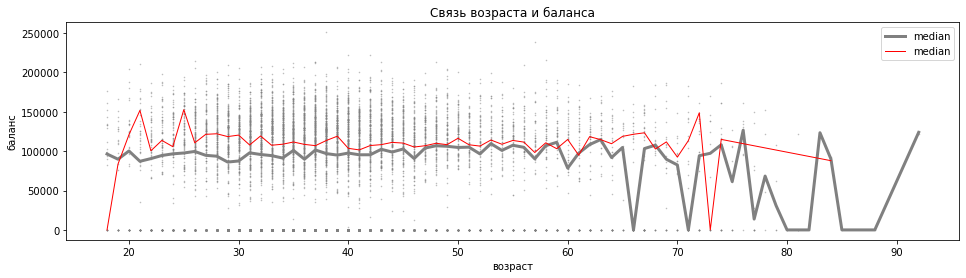

In [62]:
# график scatterplot: balance - age
# график lineplot: медиана balance

plt.figure(figsize=(16, 4))

# точечный график
plt.scatter(data['age'], data['balance'],
           s=.3, c='grey', alpha=0.5)

# линейный график
plt.plot(data.groupby('age').agg({'balance':'median'}),
        c='grey', label='median', linewidth=3)

# линейный график ушедшие клиенты
plt.plot(data.query('churn == 1').groupby('age').agg({'balance':'median'}),
        c='red', label='median', linewidth=1)

plt.legend()
plt.title('Связь возраста и баланса')
plt.xlabel('возраст')
plt.ylabel('баланс');

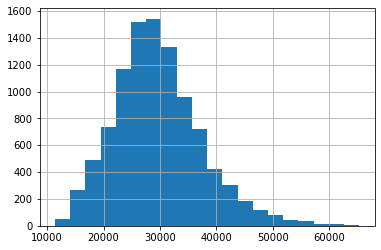

In [63]:
# построим признак: balance/age
# для распределения близкого к нормальному прибавим к estimated_salary 1_000_000

data['balance_age'] = (data['balance']+1_000_000)/data['age']

data['balance_age'].hist(bins=20);

In [64]:
# сгруппируем значения баланс_возраст

balance_age_group = np.arange(0, data['balance_age'].max() + 5_000, 5_000)

data['balance_age_group'] = pd.cut(data['balance_age'], balance_age_group)

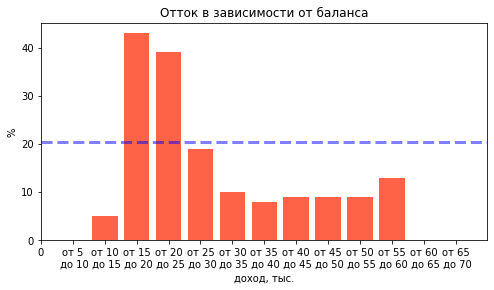

In [65]:
# настройка шкалы Х
x_label = set_xlabel(balance_age_group, multiplier=1000)

# замена шкалы Х
xticks=[np.arange(len(balance_age_group)-1), x_label]

plt.figure(figsize=(8, 4))

balance_age_group_churn = churn.churn_total('balance_age_group')

churn_bar_plot(balance_age_group_churn, 
              title='Отток в зависимости от баланса'
              )
plt.xticks(*xticks)
plt.xlabel('доход, тыс.');

## f1 scorrer

In [66]:
# для оценки качества моделей будем использовать метрику - F1

f1_scorer = make_scorer(f1_score)

## Базовая модель

### Разделение на обучающую и тестовую выборки

In [67]:
X = data[['city', 'gender', 'objects', 'balance_group', 'products', 'credit_card',
         'loyalty', 'estimated_salary_group', 'score_group', 'age_group']]

y = data['churn']

In [68]:
X_train,X_test, y_train,y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

In [69]:
dummy_pipe = Pipeline(steps=[('OHE', OneHotEncoder(handle_unknown='ignore')),
                             ('DummyClassifier', DummyClassifier(strategy='constant', constant=1))])

In [70]:
# base cross validation

dummy_cv = cross_val_score(dummy_pipe, X_test, y_test, cv=5, scoring=f1_scorer)

In [71]:
print(f'базовая модель\nf1 метрика: {dummy_cv.mean():.3f}')

базовая модель
f1 метрика: 0.338


## LogisticRegression

In [72]:
# LogisticRegressionR pipeline

log_r_pipe = Pipeline(steps= [('OHE', OneHotEncoder(handle_unknown='ignore')),
                              ('LogisticRegression', LogisticRegression(class_weight='balanced',
                                    random_state=RANDOM_STATE, n_jobs=-1))
                             ]
                     )

In [73]:
log_r_cv = cross_val_score(log_r_pipe, X_train, y_train, cv=5, scoring=f1_scorer)

In [74]:
print(f'LogisticRegression\nf1 метрика: {log_r_cv.mean():.3f}')

LogisticRegression
f1 метрика: 0.575


In [75]:
# попробуем подобрать "порог"

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

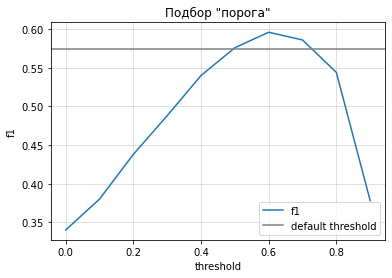

In [76]:
f1_list = []

X_train_reset_index = X_train.reset_index(drop=True).copy()
y_train_reset_index = y_train.reset_index(drop=True).copy()

for train_idx, valid_idx in kf.split(X_train_reset_index, y_train_reset_index):
    
    # обучающая выборка
    X_tr = X_train_reset_index.loc[train_idx]
    y_tr = y_train_reset_index.loc[train_idx]
    
    # валидационная выборка
    X_val = X_train_reset_index.loc[valid_idx]
    y_val = y_train_reset_index.loc[valid_idx]
    
    # обучаение
    log_r_pipe.fit(X_tr, y_tr)
    
    # мера уверенности модели
    probabilities = log_r_pipe.predict_proba(X_val)
    probabilities_one_valid = probabilities[:, 1]

    # перебираем порог
    for threshold in np.arange(0, 1, 0.1):
        predicted_valid = probabilities_one_valid > threshold
        f1 = f1_score(y_val, predicted_valid)
        
        # записываем результат
        f1_list.append({'threshold': threshold.round(1), 'f1' : f1.round(2)})

# преобразуем в df       
f1_list = pd.DataFrame(f1_list)

# считаем среднее
f1_list.groupby('threshold').agg({'f1':'mean'}).plot()
plt.grid(alpha=0.5)
plt.title('Подбор "порога"')
plt.ylabel('f1')
plt.axhline(log_r_cv.mean(), label='default threshold', color='grey')
plt.legend();

___
незначительно смогли улучшить метрику
___

In [77]:
# визуализация важности признаков

def feature_importance_func(model_ = log_r_pipe,
                            figsize=(12, 12),
                            importance_less=0,
                            importance_more=0):
    '''
    функция визуализирует важность параметров для модели
    '''
    
    features_name = []

    for feature in model_[0].get_feature_names_out():
        features_name.append(feature)
        
    model_coef = model_[1].coef_

    feature_importance = {}

    for feature, importance in zip(features_name, model_coef[0]):
        feature_importance[feature] = importance
        
    importances = pd.DataFrame.from_dict(feature_importance, orient='index').rename(columns={0: 'Важность'})
    importances = importances.sort_values(by='Важность')
    importances = importances.reset_index()
    importances = importances.rename(columns={'index': 'Признак'})
    
    importances = importances.query('(Важность<=@importance_less) | (Важность>=@importance_more) ')
    
    fig, ax = plt.subplots(figsize = figsize)
    
    plt.barh(importances['Признак'], importances['Важность'])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    
    plt.title('Важность признаков', size = 24, loc='left', y= 1.05)
    plt.ylabel('Признак', color='grey')
    plt.xlabel('Важность', color='grey')

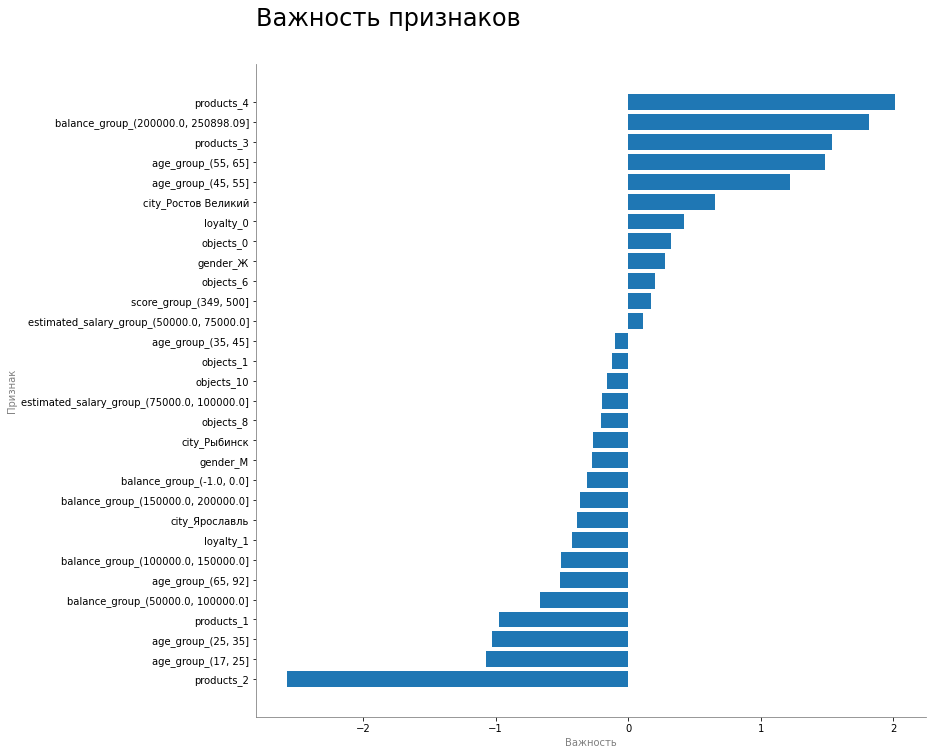

In [78]:
feature_importance_func(model_ = log_r_pipe,
                                 importance_less=-0.1,
                                 importance_more=0.1)

### LogisticRegression_feature engineering 

In [79]:
# добавим сконструированные признаки

X_fe = data[['city', 'gender', 'objects', 'balance_group', 'products', 'credit_card',
         'loyalty', 'estimated_salary_group', 'score_group', 'age_group'
             , 'balance_age_group', 'estimated_salary_age_group']]

y_fe = data['churn']

In [80]:
X_train_fe,X_test_fe, y_train_fe,y_test_fe = train_test_split(X_fe, y_fe, test_size=0.2,
                                                              stratify=y_fe, random_state=RANDOM_STATE)

In [81]:
# LogisticRegression feature engineering pipeline

log_r_pipe_fe = Pipeline(steps= [('OHE', OneHotEncoder(handle_unknown='ignore')),
                                 ('LogisticRegression', LogisticRegression(class_weight='balanced',
                                    random_state=RANDOM_STATE, n_jobs=-1))
                             ]
                     )

In [82]:
log_r_cv_fe = cross_val_score(log_r_pipe_fe, X_train_fe, y_train_fe, cv=5, scoring=f1_scorer)

In [83]:
print(f'LogisticRegression\nf1 метрика: {log_r_cv_fe.mean():.3f}')

LogisticRegression
f1 метрика: 0.580


незначительно смогли улучшить метрику

In [84]:
log_r_pipe_fe.fit(X_train_fe, y_train_fe)

Pipeline(steps=[('OHE', OneHotEncoder(handle_unknown='ignore')),
                ('LogisticRegression',
                 LogisticRegression(class_weight='balanced', n_jobs=-1,
                                    random_state=123))])

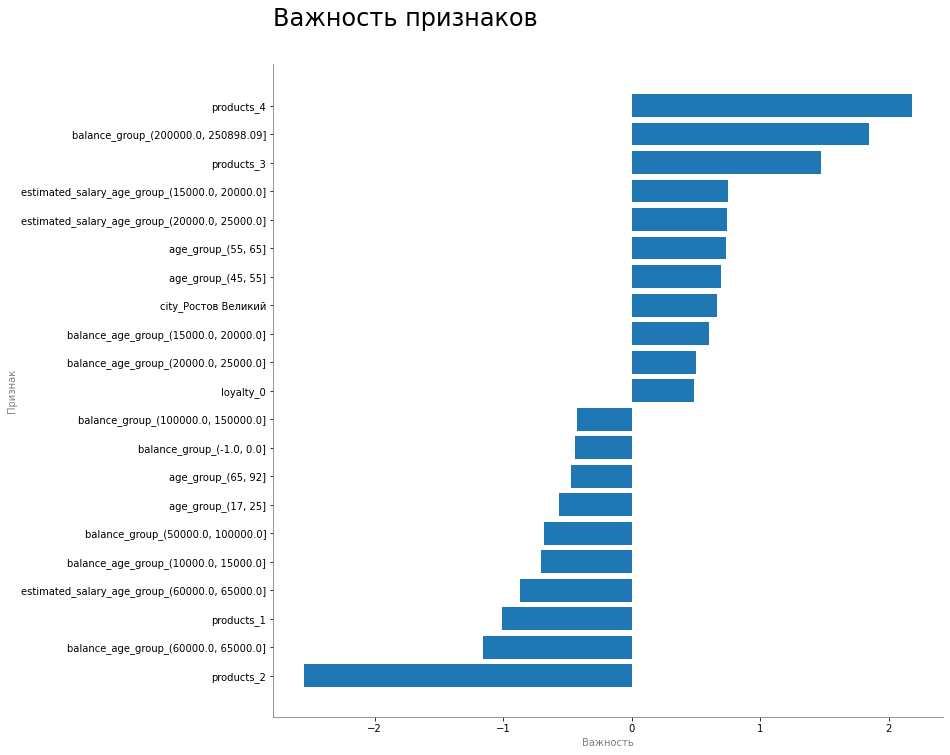

In [85]:
feature_importance_func(model_ = log_r_pipe_fe,
                                 figsize=(12, 12),
                                 importance_less=-0.4,
                                 importance_more=0.4
                       )

___
__Можем отметить__ появление сконструированных признаков среди признаков с наибольшим весом для прогноза ухода клиента
___

## Catboost

In [86]:
X_cat = data[['city', 'gender', 'objects', 'balance', 'products', 'credit_card',
         'loyalty', 'estimated_salary', 'score', 'age',
         'estimated_salary_age', 'balance_age']]

y_cat = data['churn']

In [87]:
X_train_cat,X_test_cat, y_train_cat,y_test_cat = train_test_split(
    X_cat, y_cat, test_size=0.2, stratify=y_cat, random_state=RANDOM_STATE
    )

In [88]:
cat_classifier = CatBoostClassifier(random_seed=RANDOM_STATE, eval_metric='F1', verbose=False)

In [89]:
# попробуем подобрать "порог"

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [90]:
cat_cv_f1_list = []
cat_threshold_f1_list = []

X_cat_train_reset_index = X_train_cat.reset_index(drop=True).copy()
y_cat_train_reset_index = y_train_cat.reset_index(drop=True).copy()

for train_idx, valid_idx in kf.split(X_cat_train_reset_index, y_cat_train_reset_index):
    
    # обучающая выборка
    X_cat_tr = X_cat_train_reset_index.loc[train_idx]
    y_cat_tr = y_cat_train_reset_index.loc[train_idx]
    
    # валидационная выборка
    X_cat_val = X_cat_train_reset_index.loc[valid_idx]
    y_cat_val = y_cat_train_reset_index.loc[valid_idx]
    
    # обучаение
    cat_classifier.fit(X_cat_tr, y_cat_tr,
                       eval_set=(X_cat_val, y_cat_val),
                       cat_features = ['city', 'gender']
                      )
    
    cat_cv_f1_list.append(cat_classifier.best_score_['validation']['F1'])
    
    # мера уверенности модели
    probabilities = cat_classifier.predict_proba(X_cat_val)
    probabilities_one_valid = probabilities[:, 1]

    # перебираем порог
    for threshold in np.arange(0, 1, 0.1):
        predicted_valid = probabilities_one_valid > threshold
        f1 = f1_score(y_cat_val, predicted_valid)
        
        # записываем результат
        cat_threshold_f1_list.append({'threshold': threshold.round(1), 'f1' : f1.round(2)})

In [91]:
print(f'CatBoost\nf1 метрика: {np.mean(cat_cv_f1_list):.3f}')

CatBoost
f1 метрика: 0.607


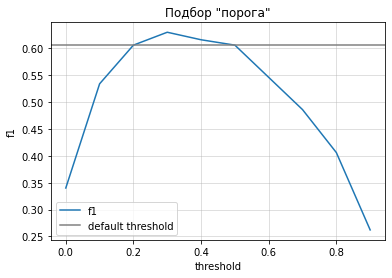

In [92]:
# преобразуем в df       
cat_threshold_f1_list = pd.DataFrame(cat_threshold_f1_list)

# считаем среднее
cat_threshold_f1_list.groupby('threshold').agg({'f1':'mean'}).plot()
plt.grid(alpha=0.5)
plt.title('Подбор "порога"')
plt.ylabel('f1')
plt.axhline(np.mean(cat_cv_f1_list), label='default threshold', color='grey')
plt.legend();

___
Модель показала немного лучший результат
___

## Проверка лучшей модели на тестовой выборке

In [93]:
cat_classifier.fit(X_train_cat, y_train_cat, cat_features = ['city', 'gender'])

In [94]:
print(f'CatBoost\nf1 на тестовой выборке: {f1_score(y_test_cat, cat_classifier.predict(X_test_cat)):.3f}')

CatBoost
f1 на тестовой выборке: 0.616


In [95]:
print(f'CatBoost\nprecision на тестовой выборке:\
{precision_score(y_test_cat, cat_classifier.predict(X_test_cat)):.3f}')

CatBoost
precision на тестовой выборке:0.764


In [96]:
print(f'CatBoost\nrecall на тестовой выборке:\
{recall_score(y_test_cat, cat_classifier.predict(X_test_cat)):.3f}')

CatBoost
recall на тестовой выборке:0.516


# Выводы

В рамках проекта был проведен анализ данных для выделения сегментов клиентов склонных к отказу от услуг банка.

**Выяснили:**
 
1  **Общий отток**. Уходит каждый пятый клиент (отток 20.4%); <br/>
<br/>
2 **Влияние региона присутствия**. В Ростове Великом уходит каждый третий клиьент (отток: 32.0%). <br/>
**Возможные причины:**
- можно отметить различие в распределении оттока (в отделениях в Ростове Великом и Ярославле, Рыбинске) клиентов по уровню баланса . Можно предположить, что в отделении в Ростове Великом попытались сократить отток клиентов с определенным уровнем баланса. Добились успеха, но при этом ухудшили показатели по другим группам;
- в отделениях различные продукты.

**Рекомендации:**
- провести соппоставление продуктов, условий по продуктам между отделениями;
- провести аудит соблюдения корпоративных стандартов.
<br/>

3 **Активность клиентов**. Неактивные клиенты уходят в два раза чаще чем активные (отток: 27%).<br/>
**Возможные причины:**<br/>
Разделим причины перехода в неактивный режим и различий в оттоке между активными и неактивными клиентами.<br/>
Причины перехода в неактивный режим:
- Методология определения. Следует уточнить параметры неактивности: отсутсвие каких-либо операций за период, опять же - какой? Клиент с долгосрочным депозитом (3 года) будет неактивным? и т.д.
- возможная смена з/п проекта работадателем, смена банка для начисления социальных пособий и т.д. Т.е. Клиент перешел в другой банк, но договор обсуживания не разорвал. <br/>
Причины повышенного оттока неактивных клиентов:
- неактивные клиенты все реже вспоминают про банк или не находят подходящих продуктов, со временем совсем отказываются;
- Методология учета. Что происходит с неактивными клиентами, которые не уходят, так и остаются неактивными или удается перевести в статус активных. т.е. клиенты из неактивных не попадают в статистику оттока, а переходят в активные?

**Рекомендации:**
- напоминать клиентам о банке и его продуктах;
- предлагать специальные условия по продуктам.

4 **Кредитный рейтинг**. Клиенты с низким кредитным рейтингм (350-450) уходят чаще (отток: 32%).<br/>
**Возможные причины:**
- менее ответсвенны;
- менее обдуманно подходили к выбору банка и продуктов;
- возможно более импульсивны.

**Рекомендации:**
- клиенты с низким рейтингом самая малочисленная группа - 61 клиент или 0.61% от общей численности клиентов. Возможно ввиду малой выборки это случайность, но нужно смотреть насколько ответсвенно ведет себя данная категория клиентов и насколько выгодно банку с ними сотрудничать.

5 **Количество продуктов**. Клиенты оформившие 3 и 4 продукта уходя практически все (отток 83% и 100%). Также многие клиенты с одим продуктом не смогли оценить преимущества банка (отток: 28%);<br/>
**Возможные причины:**
- чем больше продуктов, тем выше стоимость обслуживания продуктов (в случае кредитных продуктов);
- чем больше продуктов тем больше вероятность получить негативный опыт использования хотя бы одного;
- клиенты использующие один продукт могут как получить негативный опыт использования так и положительный, тогда могут оформить второй продукт, т.е. более лояльные клиенты перешли в категорию с двумя продуктами, а в категории с одним продуктом осталось больше неопределившихся.

**Рекомендации:**
- провести анализ сценариев оформления 2, 3, 4 продуктов;
- повысить удовлетворенность клиентов от использования первого продукта банка.

6 **Количество объектов в собственности** не влияет на вероятность оттока.


7 **Оформление кредитной карты**. Оформление кредитной карты никака не влияет на вероятность ухода.

8 **Баланс**. Чаще уходят клиенты с балансом до 50 000р. и от 175 000р. (отток: 35% и 29%).<br/>
**Возможные причины:**
- продукты банка не ориентированы на работу с таким уровнем баланса.

**Рекомендации:**
- это самые малочисленные группы. Необходим дополнительный анализ насколько данные группы являются целевыми и перспективными.

9 **Оценочный уровень дохода**. Оценочный уровень дохода не влияет на вероятность ухода.

10 **Возраст**. Клиенты от 45 до 65 лет уходят чаще (отток: 51% и 48%).<br/>
**Возможные причины:**<br/>
Можно рассмотреть:<br/>
внутренние причины:<br/>
- клиенты данной возрастной категории получают менее положительный опыт взаимодействия с банком (обслуживание в отделении, интернет, мобильный банк);
- различие в тарифах на обслсуживание (повышенные, пониженные комиссии, процентные ставки и т.д)<br/>

внешние причины:
- смена зарплатных проетов крупных работадателей региона;
- агрессивная стратегия конкурентов направленная на конкретные группы.

**Рекомендации:**
- данные возрастные группы не самые большие. Суммарно численность данной группы занимает 3-е место по размеру (18% от ощего количества) и в два раза меньше чем группа занимающая второе место (37% от общего количества) по размеру.
- для рекомендаций необходимо знать стратегию банка и понимать насколько данные группы являются целевыми. Также выявить основные причины(подтвердить/ опровергнуть выдвинутые предположения о причинах оттока клиентов).

11 **Пол.** Женщины более склонны к отказу от услуг банка (25% оттока).<br/>
**Возможные причины:**<br/>
Можно рассмотреть:<br/>
внутренние причины:<br/>
- женщины более требовательны к уровню сервиса;
- различие в тарифах;<br/>

внешние причины:
- конкурент нацеленный на женскую аудиторию.

**Рекомендации:**
- женщины составляли 45% клиентов банка. Т.е. в данном случае нельзя сказать, что не являются целевыми клиентами. Однако, до конца не понимая причин, сложно предоставить конктретные рекомендации. Нужен дополнительный анализ как причин оттока, так и возможностей устранения причин, например, если причина внешняя, в более привлекательных тарифах конкурентов, можем ли устраивать "войну" тарафов.

Для ответа на вопрос: отток в каком сегменте повлиял на обращение менеджера продукта, необходимо провести анализ <предыдущий период>/<текущий период>. Без подобного анализа невозможно ответить изменился показатель оттока в каком-то одном или нескольких сегментах.

__Разработка прототипа ML модели__

_Задачи:_ <br/>
- Построение прототипа модели, которая будет предсказывать уход клиента.

__Критерии качества:__
- F1 - 0.59;
- требований к скорости обучения и предсказания не задано;
- требований к интерпретируемости модели не задано.

__Основные этапы:__
_Подготовка признаков_ <br/>
Были сформированы обучающие признаки:
- score - кредитный скоринг;
- score_group - значения кредитного скоринга объединенные в группы
- city - город;
- gender - пол;
- age - возраст;
- age_group - возрастная группа;
- objects - количество объктов;
- balance - баланс;
- balance_group - баланс оъединенный в группы;
- products - количество продуктов;
- credit_card - наличие кредитной карты;
- loyalty - активность;
- estimated_salary - оценочный доход;
- estimated_salary_age_group - оценочный доход оъединенный в группы;
- estimated_salary_age - оценочный доход/возраст;
- estimated_salary_age_group - оценочный доход/возраст оъединенный в группы;
- balance_age - баланс/возраст;
- balance_age_group - баланс/возраст оъединенный в группы.

Целевой признак:
- churn.

_Обучение моделей_ <br/>
Для обучения моделей использовался гиперпараметр random_state = 123

- Базовая модель. Значение F1 = 0.338;<br/>
- Линейная модель. Значение F1 = 0.580 <br/>
- Градиентный бустинг (CatBoost).Значение на F1 = 0.607 <br/>

Лучшее значение показала модель градиентного бустинга. Значения на тесте - 0.616